# Options Greeks Calculator & Payoff Visualizer (Black–Scholes)

**Goal:** Build an options analytics mini‑tool that:

- Prices European call and put options using the Black–Scholes model.
- Computes the main option Greeks (Delta, Gamma, Vega, Theta, Rho).
- Visualizes option payoffs at expiry for long/short positions.
- Explores how price and Greeks change with the underlying or volatility.


## 1. Black–Scholes Model Setup

We work with the classic Black–Scholes–Merton framework for European options:

- Underlying price: $S$
- Strike price: $K$
- Risk‑free rate: $r$
- Volatility (annualized): $\sigma$
- Time to maturity (in years): $T$

The Black–Scholes formula for a European call option price is:

$$
C = S \Phi(d_1) - K e^{-rT} \Phi(d_2)
$$

and for a put:

$$
P = K e^{-rT} \Phi(-d_2) - S \Phi(-d_1)
$$

where:

$$
d_1 = \frac{\ln(S/K) + (r + \sigma^2/2)T}{\sigma \sqrt{T}}, \quad
d_2 = d_1 - \sigma \sqrt{T}.
$$

$\Phi(d)$ is the standard normal CDF.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm

plt.style.use("seaborn-v0_8-darkgrid")


## 2. Implementing Black–Scholes Pricing in Python

We first implement helper functions to compute:

- $d_1$ and $d_2$ for given $S, K, r, \sigma, T$
- Call and put prices from the Black–Scholes formula

These functions will be reused to compute Greeks and build payoff diagrams.


In [3]:
def black_scholes_price(S, K, r, sigma, T, option_type="call"):
    """
    S: spot price
    K: strike price  
    r: risk-free rate
    sigma: volatility
    T: time to maturity (years)
    option_type: "call" or "put"
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type.lower() == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    return price


In [10]:
# Example parameters
S = 100   # spot
K = 100   # strike
r = 0.05  # 5% risk-free
sigma = 0.2  # 20% vol
T = 0.5   # 0.5 years

call_price = black_scholes_price(S, K, r, sigma, T, "call")
put_price  = black_scholes_price(S, K, r, sigma, T, "put")

print(f"Call: {call_price:.4f}, Put: {put_price:.4f}")


Call: 6.8887, Put: 4.4197


For at-the-money options (S = K = 100, T = 0.5, r = 5%, σ = 20%), we obtain reasonable call and put prices from the Black–Scholes model. These functions form the base for calculating Greeks and constructing payoff diagrams.


## 3. Option Greeks 

The main Greeks measure how the option price reacts to small changes in inputs:

- **Delta**: sensitivity to underlying price $S$
- **Gamma**: sensitivity of Delta to $S$
- **Vega**: sensitivity to volatility $\sigma$
- **Theta**: sensitivity to time (time decay)
- **Rho**: sensitivity to interest rate $r$

For European options in the Black–Scholes model, these have closed‑form expressions in terms of $d_1$ and $d_2$. We now implement analytic formulas for call and put Greeks.


In [5]:
import numpy as np
from scipy.stats import norm

def black_scholes_greeks(S, K, r, sigma, T, option_type="call"):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    pdf_d1 = norm.pdf(d1)
    cdf_d1 = norm.cdf(d1)
    cdf_d2 = norm.cdf(d2)
    
    if option_type.lower() == "call":
        delta = cdf_d1
        gamma = pdf_d1 / (S * sigma * np.sqrt(T))
        vega = S * pdf_d1 * np.sqrt(T) / 100  # Per 1% change
        theta = (-S * pdf_d1 * sigma / (2 * np.sqrt(T)) 
                 - r * K * np.exp(-r * T) * cdf_d2) / 365  # Per day
        rho = K * T * np.exp(-r * T) * cdf_d2 / 100  # Per 1% rate change
        
    else:  # put
        delta = cdf_d1 - 1
        gamma = pdf_d1 / (S * sigma * np.sqrt(T))
        vega = S * pdf_d1 * np.sqrt(T) / 100
        theta = (-S * pdf_d1 * sigma / (2 * np.sqrt(T)) 
                 + r * K * np.exp(-r * T) * norm.cdf(-d2)) / 365
        rho = -K * T * np.exp(-r * T) * norm.cdf(-d2) / 100
    
    return {"delta": delta, "gamma": gamma, "vega": vega, 
            "theta": theta, "rho": rho}


In [17]:
greeks_call = black_scholes_greeks(S, K, r, sigma, T, "call")
greeks_put  = black_scholes_greeks(S, K, r, sigma, T, "put")

print("Greek      | Call    | Put")
print("-" * 30)
for greek in ["delta", "gamma", "vega", "theta", "rho"]:
    call_val = greeks_call[greek]
    put_val = greeks_put[greek]
    print(f"{greek:10} | {call_val:7.4f} | {put_val:7.4f}")

Greek      | Call    | Put
------------------------------
delta      |  0.5977 | -0.4023
gamma      |  0.0274 |  0.0274
vega       |  0.2736 |  0.2736
theta      | -0.0222 | -0.0089
rho        |  0.2644 | -0.2232


## 4. Payoff Functions at Expiry

The **payoff** at expiry depends only on the final underlying price $S_T$:

- Long call payoff: $\max(S_T - K, 0)$
- Long put payoff:  $\max(K - S_T, 0)$

For short positions, the payoff is simply the negative of the long payoff.

We now implement simple payoff functions and will use them to plot payoff diagrams
for different option positions.


In [18]:
def call_payoff(S_T, K, position="long", quantity=1):
    """
    Payoff at expiry for a simple European call.

    S_T: array of underlying prices at expiry
    position: "long" or "short"
    quantity: number of contracts (scalar)
    """
    S_T = np.array(S_T, dtype=float)
    payoff = np.maximum(S_T - K, 0.0)
    if position.lower() == "short":
        payoff = -payoff
    return quantity * payoff


def put_payoff(S_T, K, position="long", quantity=1):
    """
    Payoff at expiry for a simple European put.
    """
    S_T = np.array(S_T, dtype=float)
    payoff = np.maximum(K - S_T, 0.0)
    if position.lower() == "short":
        payoff = -payoff
    return quantity * payoff


## 5. Visualizing Payoff Diagrams

We can now visualize the payoff at expiry as a function of the underlying price
$S_T$ for:

- Long call
- Long put

These diagrams are a standard way to understand the asymmetry and risk profile
of option positions.


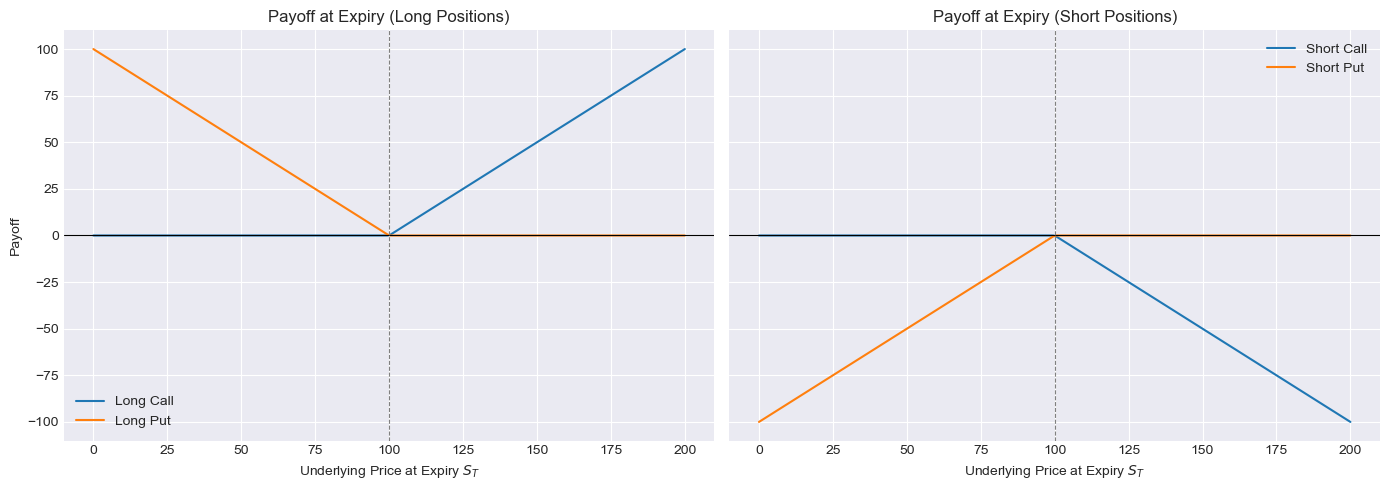

In [19]:
# Range of possible prices at expiry
S_T = np.linspace(0, 2 * K, 200)

long_call_payoff = call_payoff(S_T, K, position="long")
long_put_payoff  = put_payoff(S_T, K, position="long")

short_call_payoff = call_payoff(S_T, K, position="short")
short_put_payoff  = put_payoff(S_T, K, position="short")

fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

# Long positions
ax[0].plot(S_T, long_call_payoff, label="Long Call")
ax[0].plot(S_T, long_put_payoff, label="Long Put")
ax[0].axhline(0, color="black", linewidth=0.8)
ax[0].axvline(K, color="gray", linestyle="--", linewidth=0.8)
ax[0].set_title("Payoff at Expiry (Long Positions)")
ax[0].set_xlabel("Underlying Price at Expiry $S_T$")
ax[0].set_ylabel("Payoff")
ax[0].legend()

# Short positions
ax[1].plot(S_T, short_call_payoff, label="Short Call")
ax[1].plot(S_T, short_put_payoff, label="Short Put")
ax[1].axhline(0, color="black", linewidth=0.8)
ax[1].axvline(K, color="gray", linestyle="--", linewidth=0.8)
ax[1].set_title("Payoff at Expiry (Short Positions)")
ax[1].set_xlabel("Underlying Price at Expiry $S_T$")
ax[1].legend()

plt.tight_layout()
plt.show()


## 6. Delta as a Function of Underlying Price

To understand how sensitivity changes across moneyness, we can fix
$K, r, \sigma, T$ and vary the underlying price $S$.

We then plot:

- Call Delta vs $S$
- Put Delta vs $S$

This shows how calls approach Delta ≈ 1 when deep in‑the‑money and 0 when deep
out‑of‑the‑money, while puts move from 0 to −1.


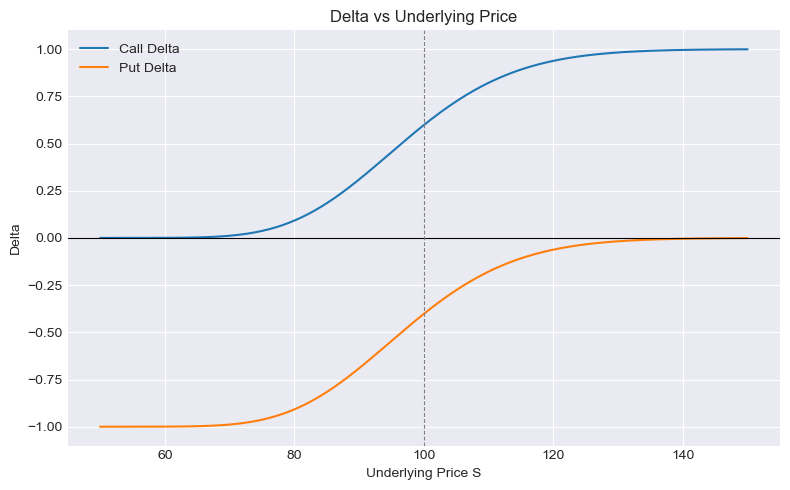

In [20]:
S_grid = np.linspace(0.5 * K, 1.5 * K, 200)

call_deltas = black_scholes_greeks(S_grid, K, r, sigma, T, "call")["delta"]
put_deltas  = black_scholes_greeks(S_grid, K, r, sigma, T, "put")["delta"]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(S_grid, call_deltas, label="Call Delta")
ax.plot(S_grid, put_deltas, label="Put Delta")
ax.axhline(0, color="black", linewidth=0.8)
ax.axvline(K, color="gray", linestyle="--", linewidth=0.8)
ax.set_title("Delta vs Underlying Price")
ax.set_xlabel("Underlying Price S")
ax.set_ylabel("Delta")
ax.legend()
plt.tight_layout()
plt.show()


## 7. Option Price vs Volatility

For fixed $S, K, r, T$, the Black–Scholes price increases with volatility
because options benefit from uncertainty.

Here we fix $S = K = 100$, $r = 5\%$, $T = 0.5$ years and vary
$\sigma$ from 5% to 80%, plotting the call price as a function of volatility.


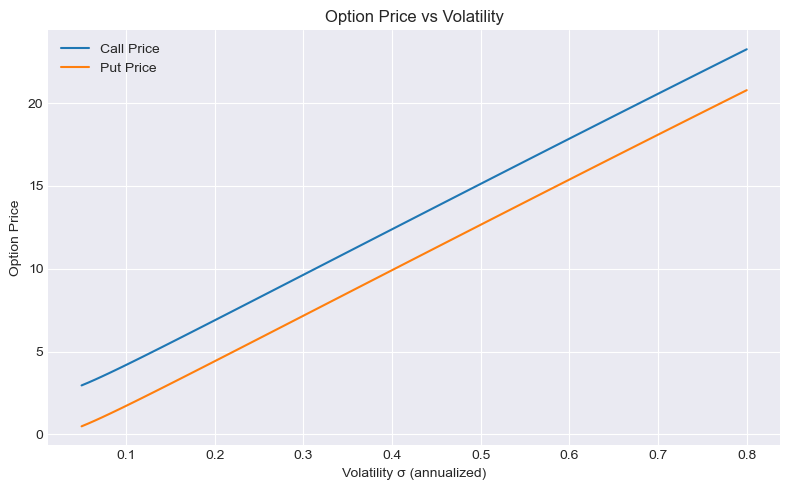

In [21]:
vol_grid = np.linspace(0.05, 0.80, 100)

call_prices_vs_vol = black_scholes_price(S, K, r, vol_grid, T, "call")
put_prices_vs_vol  = black_scholes_price(S, K, r, vol_grid, T, "put")

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(vol_grid, call_prices_vs_vol, label="Call Price")
ax.plot(vol_grid, put_prices_vs_vol, label="Put Price")
ax.set_title("Option Price vs Volatility")
ax.set_xlabel("Volatility σ (annualized)")
ax.set_ylabel("Option Price")
ax.legend()
plt.tight_layout()
plt.show()


## 8. Example Use Case: Hedging a Call Option

To illustrate how this tool can be used, consider the following scenario:

- Underlying: NIFTY-like index
- Spot price: $S = 20000$
- Strike: $K = 20000$ (at-the-money)
- Time to maturity: $T = 0.25$ years (3 months)
- Volatility: $\sigma = 20\%$
- Risk-free rate: $r = 6\%$

A trader is **long one call option** and wants to understand:

- The fair value of the option under Black–Scholes
- How many units of the underlying are needed to delta-hedge
- How the P&L behaves at expiry

We compute the price and Greeks and then show the payoff and Delta profile.


In [22]:
# Example scenario
S0 = 20000
K0 = 20000
r0 = 0.06
sigma0 = 0.20
T0 = 0.25

call_price_0 = black_scholes_price(S0, K0, r0, sigma0, T0, "call")
call_greeks_0 = black_scholes_greeks(S0, K0, r0, sigma0, T0, "call")

call_price_0, call_greeks_0


(np.float64(949.3772321480501),
 {'delta': np.float64(0.579259709439103),
  'gamma': np.float64(0.00019552134698772795),
  'vega': np.float64(39.104269397545586),
  'theta': np.float64(-6.0337528583557924),
  'rho': np.float64(26.589542391585024)})

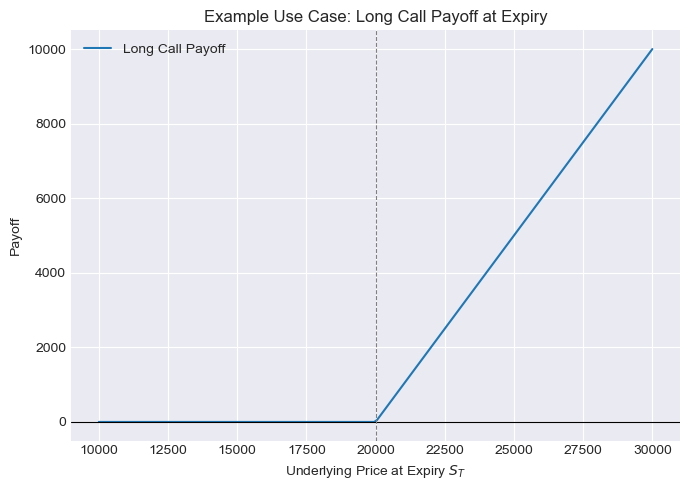

In [23]:
# payoff function
def call_payoff(S_T, K, position="long", quantity=1):
    S_T = np.array(S_T, dtype=float)
    payoff = np.maximum(S_T - K, 0.0)
    if position.lower() == "short":
        payoff = -payoff
    return quantity * payoff

# Price grid around S0
S_T_grid = np.linspace(0.5 * S0, 1.5 * S0, 200)
long_call_payoff_example = call_payoff(S_T_grid, K0, position="long")

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(S_T_grid, long_call_payoff_example, label="Long Call Payoff")
ax.axhline(0, color="black", linewidth=0.8)
ax.axvline(K0, color="gray", linestyle="--", linewidth=0.8)
ax.set_title("Example Use Case: Long Call Payoff at Expiry")
ax.set_xlabel("Underlying Price at Expiry $S_T$")
ax.set_ylabel("Payoff")
ax.legend()
plt.tight_layout()
plt.show()


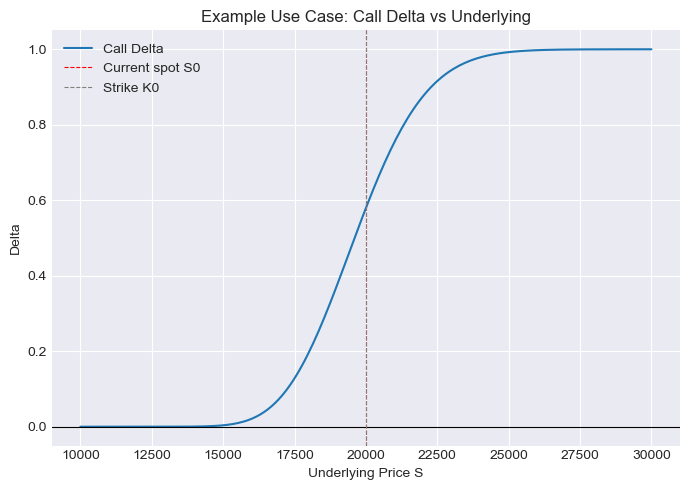

In [24]:
S_grid_example = np.linspace(0.5 * S0, 1.5 * S0, 200)
call_deltas_example = black_scholes_greeks(
    S_grid_example, K0, r0, sigma0, T0, "call"
)["delta"]

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(S_grid_example, call_deltas_example, label="Call Delta")
ax.axhline(0, color="black", linewidth=0.8)
ax.axvline(S0, color="red", linestyle="--", linewidth=0.8, label="Current spot S0")
ax.axvline(K0, color="gray", linestyle="--", linewidth=0.8, label="Strike K0")
ax.set_title("Example Use Case: Call Delta vs Underlying")
ax.set_xlabel("Underlying Price S")
ax.set_ylabel("Delta")
ax.legend()
plt.tight_layout()
plt.show()


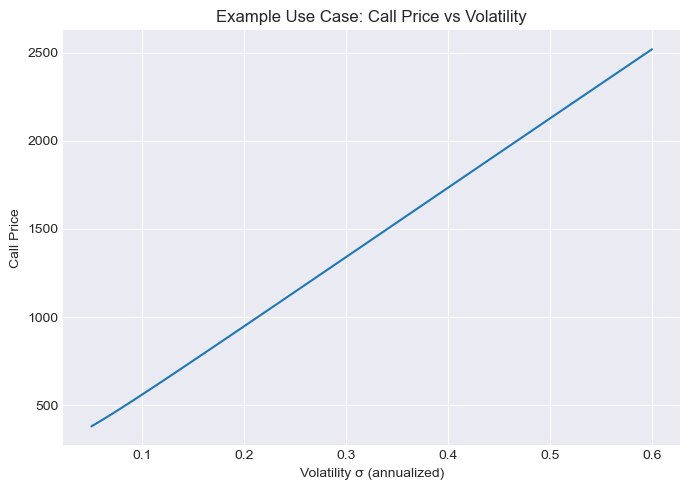

In [25]:
vol_grid_example = np.linspace(0.05, 0.60, 80)
call_prices_vs_vol_example = black_scholes_price(
    S0, K0, r0, vol_grid_example, T0, "call"
)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(vol_grid_example, call_prices_vs_vol_example)
ax.set_title("Example Use Case: Call Price vs Volatility")
ax.set_xlabel("Volatility σ (annualized)")
ax.set_ylabel("Call Price")
plt.tight_layout()
plt.show()


In this example, the call price gives the theoretical premium, and Delta tells us
how many units of the underlying are needed for a local delta hedge. For instance,
Delta ≈ 0.5 implies hedging one long call with a short position of approximately
0.5 units of the underlying index.

The payoff diagram at expiry shows the asymmetric upside: limited downside (premium
paid) and unlimited upside as the underlying rises above the strike.


## 9. Conclusion

In this notebook, the Black–Scholes model was implemented to price European call
and put options, along with closed-form formulas for the main Greeks (Delta,
Gamma, Vega, Theta, and Rho).

Payoff diagrams and sensitivity plots (Delta vs underlying price, option price
vs volatility) were used to build intuition about how option value and risk
change with market conditions.

Finally, an example hedging use case demonstrated how these tools can be applied
in practice to understand the risk profile of a simple long call position and
its local delta hedge.
